In [ ]:
import numpy as np
from icecream import ic
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import shutil
import scipy.stats as stats

In [13]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 3050 Laptop GPU


In [14]:
torch.manual_seed(3456)
torch.cuda.manual_seed_all(3456)
numOfparticles=10000
a=torch.arange(0,numOfparticles,1)
length=2000
r=(torch.rand(device="cuda",size=(numOfparticles,2))-0.5)*2*length
ids=torch.arange(0,numOfparticles,device="cuda",)
vels=torch.zeros_like(r,device="cuda",)
inivel=500
radius=0.7
dt=0.01
time=60
binNumber=700
mass=1e-9

In [15]:

leftParticles=r[:,0]<=0
rightParticles=r[:,0]>0
vels[leftParticles,0]=inivel
vels[rightParticles,0]=- inivel
vels=vels+torch.rand_like(vels,device="cuda",)



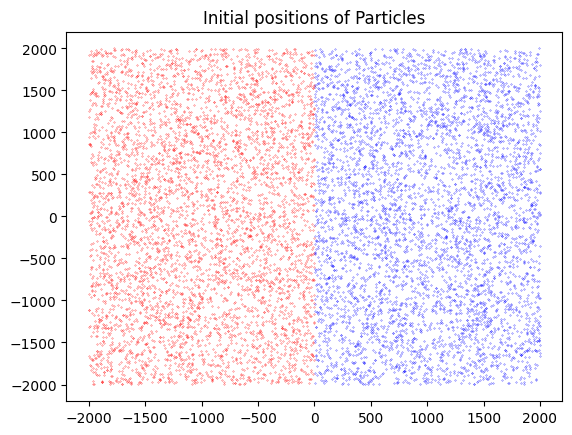

In [16]:
r_cpu=r.clone().cpu()
leftParticles_cpu=leftParticles.cpu()
rightParticles_cpu=rightParticles.cpu()
plt.scatter(r_cpu[leftParticles_cpu,0],r_cpu[leftParticles_cpu,1],s=0.05,color="red")
plt.scatter(r_cpu[rightParticles_cpu,0],r_cpu[rightParticles_cpu,1],s=0.05,color="blue")
plt.title("Initial positions of Particles")
plt.show()

path=f"{length}L,{numOfparticles}N,r{radius}/"
if(not(os.path.exists(path))):
    os.makedirs(path)

else:
    shutil.rmtree(path)
    os.makedirs(path)

In [17]:

allCombidx = torch.combinations(ids, 2).to("cuda")
def Collpairsfunc(r):
    combPosition=r[allCombidx]
    p1=combPosition[:,0]
    p2=combPosition[:,1]
    combDistance= torch.linalg.norm(p1-p2,dim=1)
    isCollision=combDistance<=2*radius
    collPairs=allCombidx[isCollision]
    return collPairs

collPairs=Collpairsfunc(r=r)
print(collPairs.shape)


torch.Size([17, 2])


In [18]:
def newVelocity(vels,r):
    collPairs=Collpairsfunc(r)
    for pair in collPairs:
        m1=pair[0]
        m2=pair[1]
        v1=vels[m1,:]
        r1=r[m1,:]
        v2=vels[m2,:]
        r2=r[m2,:]
        relPos=r1-r2+1e-10
        magrelPos=torch.dot(relPos,relPos)
        relVels=v1-v2
        vdr=torch.dot(r1-r2,relVels)
        v1Dash= v1- vdr/(magrelPos)*(relPos)
        v2Dash=v2+vdr/(magrelPos)*(relPos)
        vels[m1,:]=v1Dash
        vels[m2,:]=v2Dash
    return vels

In [19]:
def update(r,vels,dt=dt):
    r=r+(vels*dt) #type:ignore
    xRight=r[:,0]> length
    xLeft=r[:,0]< -length
    yTop=r[:,1]> length
    yBottom=r[:,1]< -length
    vels[xRight,0] *= -1
    vels[xLeft,0]  *= -1
    vels[yBottom,1]   *= -1
    vels[yTop,1]*= -1
    r[xRight,0] = 2*length- r[xRight,0]
    r[xLeft,0] = -2*length- r[xLeft,0]
    r[yTop,1]  = 2*length- r[yTop,1]
    r[yBottom,1] = -2*length- r[yBottom,1]
    vels = newVelocity(vels, r)
    return r,vels


In [20]:
vels_cpu=vels.cpu()
magvels=torch.norm(vels_cpu,dim=1)
plt.figure(figsize=(8,4.5))
plt.hist(magvels,density=True,bins=700,color="#8E2EC7",linewidth=0.03,edgecolor="white",label=f"Mean={magvels.mean():.2f}\nStandard Deviation: {magvels.std():.2f}")
plt.title(f"Initial Probability distribution of speed ")
plt.legend(loc="upper right")
plt.xlabel("Speed of the particles")
plt.ylabel("Probablity Density")
plt.savefig(f"{length}L,{numOfparticles}N,r{radius}/Initial Distribution '.png")
plt.close()


In [21]:
nowTime=0

def graphHist(magvels,nowTime):
        plt.figure(figsize=(8,4.5))
        plt.hist(magvels,density=True,bins=binNumber,color="#8E2EC7",linewidth=0.01,edgecolor="white",label=f"Mean={magvels.mean():.2f}\nStandard Deviation: {magvels.std():.2f}")
        plt.title(f"Probability distribution of speed at {nowTime :.2f}s")
        plt.legend(loc="upper right")
        plt.xlim(0)
        plt.xlabel("Speed of the particles")
        plt.ylabel("Probablity Density")
        plt.savefig(f"{length}L,{numOfparticles}N,r{radius}/Histogram-'{nowTime :.2f} s'.png")
        plt.close()



while(nowTime<=time):
    if( (abs(nowTime%0.50)<=1e-4)):
        magvels = torch.norm(vels, dim=1)
        magvelsnp = magvels.detach().cpu().numpy()
        graphHist(magvelsnp,nowTime=nowTime)
    r,vels=update(r,vels)
    nowTime=round(nowTime+dt,2)

In [25]:
numspeed=magvelsnp #type:ignore
try:
    os.makedirs(f"{path}/Data/")
except:
    pass

np.savetxt(f"{path}/Data/speeds.txt",numspeed)
numvels=vels.cpu().numpy()
np.savetxt(f"{path}/Data/velocities.txt",numvels)

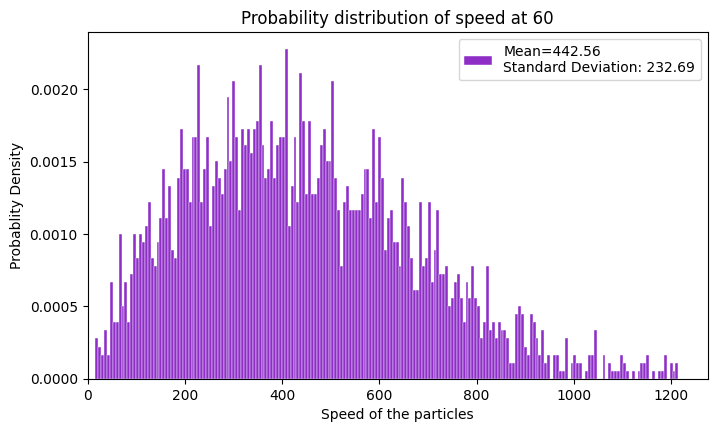

In [ ]:
plt.figure(figsize=(8,4.5))

plt.hist(
    numspeed,
    bins=binNumber,
    density=True,
    color="#8E2EC7",
    edgecolor="white",
    label=f"Mean={np.mean(numspeed):.2f}\nVariance={np.var(numspeed):.2f}"
)


sigma = np.std(numspeed)/0.655
x = np.linspace(0, max(numspeed), 4000)
pdf = stats.rayleigh(scale=sigma).pdf(x)
plt.plot(x, pdf, linestyle="--",color="grey", linewidth=2, label="Rayleigh Distribution")

plt.title(f"Speed distribution at time {time}s")
plt.legend()
plt.savefig("Outcomes 0/Final_Histogram.png")


[1, 2, 4]
